In [1]:
import pandas as pd
import pickle
import json
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import KeyedVectors
import numpy as np
import google_conf

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
mops_data = google_conf.setup(
    sheet_url="https://docs.google.com/spreadsheets/d/1VbCIAJssHKV9hlRTwzVFfm40CGnHesq53KXjv2qy4OM/edit?usp=sharing",
    service_account_path="../../ServiceAccountsKey.json")

In [3]:
metadata_df = pd.read_json("../data/metadata_rich_df.json")

In [4]:
bidecades_strs = sorted([el for el in list(set(metadata_df["bidecade"])) if el != None])
bidecades_strs

['1900-1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2019']

In [5]:
vectors_dict = {}
for bidecade in bidecades_strs:
    vectors_dict[bidecade] = KeyedVectors.load("../data/large_files/vectors_{0}_sample{1}.kv".format(bidecade, str(1000000)))

In [6]:
vectors_dict["1980-1999"].most_similar("Paul")

[('Pauls', 0.7435160279273987),
 ('Augustine', 0.6972004175186157),
 ('Origen', 0.6517276167869568),
 ('clement', 0.6188803315162659),
 ('Calvin', 0.6168031692504883),
 ('ephesian', 0.6132720708847046),
 ('Irenaeus', 0.6118727922439575),
 ('Gregory', 0.6112470626831055),
 ('thessalonian', 0.5964792370796204),
 ('Colossians', 0.5925448536872864)]

In [7]:
for bidecade in bidecades_strs:
    print(vectors_dict[bidecade].similarity("Paul", "jewish"))

0.15646729
0.20590428
0.14378823
0.20141602
0.22742748
0.16749758


In [8]:
bidecade_wordcounts = {}
for bidecade in bidecades_strs:
    bidecade_wordcounts[bidecade] = metadata_df[metadata_df["bidecade"]==bidecade]["wordCount"].sum()
bidecade_wordcounts

{'1900-1919': 5178524,
 '1920-1939': 5481199,
 '1940-1959': 11965635,
 '1960-1979': 19721863,
 '1980-1999': 46442633,
 '2000-2019': 139359545}

In [9]:
bidecades_vocabs_counts_df = pickle.load(open("../data/bidecades_vocabs_counts_df.pickle", "rb"))
bidecades_vocabs_counts_df.head(100)

,1900-1919,1920-1939,1940-1959,1960-1979,1980-1999,2000-2019
man,11218.0,8342.0,24108.0,39199.0,48435.0,100670.0
new,10183.0,10192.0,23469.0,42092.0,97421.0,293457.0
Jesus,9650.0,4911.0,12134.0,23416.0,49765.0,215687.0
et,9325.0,11818.0,20805.0,35969.0,49326.0,73464.0
God,9248.0,6276.0,26328.0,45751.0,99505.0,293240.0
...,...,...,...,...,...,...
apostle,2454.0,943.0,3288.0,4801.0,9336.0,21883.0
epistle,2431.0,1618.0,4003.0,4925.0,8343.0,18161.0
century,2427.0,3062.0,7516.0,10538.0,27068.0,96298.0
live,2427.0,2239.0,6810.0,9567.0,23213.0,77744.0


In [10]:
bidecades_vocabs_counts_df.fillna(0, inplace=True)

In [11]:
for bidecade in bidecades_strs:
    bidecades_vocabs_counts_df[bidecade + "_freq"] = bidecades_vocabs_counts_df[bidecade].apply(lambda x: x / bidecade_wordcounts[bidecade])

In [12]:
[col for col in bidecades_vocabs_counts_df.columns if "_freq" in col]

['1900-1919_freq',
 '1920-1939_freq',
 '1940-1959_freq',
 '1960-1979_freq',
 '1980-1999_freq',
 '2000-2019_freq']

In [13]:
bidecades_vocabs_counts_df["mean_freq"] = bidecades_vocabs_counts_df[[col for col in bidecades_vocabs_counts_df.columns if "_freq" in col]].apply(lambda row: np.mean(row), axis=1)
bidecades_vocabs_counts_df.sort_values("mean_freq", ascending=False, inplace=True)

In [14]:
bidecades_vocabs_counts_df.reset_index(inplace=True)
bidecades_vocabs_counts_df.head(100)

,index,1900-1919,1920-1939,1940-1959,1960-1979,1980-1999,2000-2019,1900-1919_freq,1920-1939_freq,1940-1959_freq,1960-1979_freq,1980-1999_freq,2000-2019_freq,mean_freq
0,new,10183.0,10192.0,23469.0,42092.0,97421.0,293457.0,0.001966,0.001859,0.001961,0.002134,0.002098,0.002106,0.002021
1,God,9248.0,6276.0,26328.0,45751.0,99505.0,293240.0,0.001786,0.001145,0.002200,0.002320,0.002143,0.002104,0.001950
2,Paul,8660.0,7217.0,19803.0,36061.0,100083.0,224979.0,0.001672,0.001317,0.001655,0.001828,0.002155,0.001614,0.001707
3,church,8091.0,7319.0,23104.0,39397.0,74688.0,214495.0,0.001562,0.001335,0.001931,0.001998,0.001608,0.001539,0.001662
4,see,7388.0,6783.0,18801.0,34552.0,97771.0,233655.0,0.001427,0.001238,0.001571,0.001752,0.002105,0.001677,0.001628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,case,2518.0,2565.0,4336.0,8278.0,25524.0,73865.0,0.000486,0.000468,0.000362,0.000420,0.000550,0.000530,0.000469
96,love,1874.0,1885.0,5850.0,10481.0,25420.0,72067.0,0.000362,0.000344,0.000489,0.000531,0.000547,0.000517,0.000465
97,begin,2158.0,2240.0,5284.0,9042.0,22299.0,79471.0,0.000417,0.000409,0.000442,0.000458,0.000480,0.000570,0.000463
98,biblical,1924.0,1255.0,4236.0,8867.0,27515.0,107965.0,0.000372,0.000229,0.000354,0.000450,0.000592,0.000775,0.000462


In [16]:
#google_conf.set_with_dataframe(mops_data.add_worksheet("bidecades_vocabs_counts_df", 1,1), bidecades_vocabs_counts_df)

In [17]:
pauline = ["st","saint", "apostle", "Apostle", "apostolic"]

doctrine_theology = ["christianity", "faith", "theology", "theological", "doctrine", "body", "spirit", "soul", "belief", "sacrifice", "righteousness", "justification"]

academic = ["society", "social", "tradition", "historical", "community", "religious", "religion", "science", "critical", "model", "identity", "traditional", "economic", "explanation", "scientific"] # rhetorical , gender

jewishness = ["Jews", "Jew","law", "jewish", "Israel", "hebrew", "Jerusalem", "judaism", "Moses", "Abraham", "Hebrews"]

In [18]:
source = "Paul"
targets = pauline
bidecades_data = {}
for bidecade in bidecades_strs:
    topN_mean = np.mean([tup[1] for tup in vectors_dict[bidecade].most_similar(source, topn=10)])
    bidecade_list = []
    for target in targets:
        bidecade_list.append((source, target ,{"weight" : np.round(vectors_dict[bidecade].similarity("Paul", target) / topN_mean, 2)}))
    bidecades_data[bidecade] = bidecade_list

In [19]:
bidecades_data["1920-1939"]

[('Paul', 'st', {'weight': 0.42}),
 ('Paul', 'saint', {'weight': 0.72}),
 ('Paul', 'apostle', {'weight': 0.65}),
 ('Paul', 'Apostle', {'weight': 0.81}),
 ('Paul', 'apostolic', {'weight': 0.5})]

In [20]:
G = nx.Graph()
G.add_edges_from(bidecades_data["1920-1939"])

In [21]:
G.edges(data=True)

EdgeDataView([('Paul', 'st', {'weight': 0.42}), ('Paul', 'saint', {'weight': 0.72}), ('Paul', 'apostle', {'weight': 0.65}), ('Paul', 'Apostle', {'weight': 0.81}), ('Paul', 'apostolic', {'weight': 0.5})])

In [22]:
pos = nx.circular_layout(G.subgraph(targets))
pos['Paul'] = (0, 0)
pos# pos['Paul'] = (0, 0)

{'st': array([1., 0.]),
 'saint': array([0.30901695, 0.95105657]),
 'apostle': array([-0.80901706,  0.58778526]),
 'Apostle': array([-0.809017  , -0.58778532]),
 'apostolic': array([ 0.3090171 , -0.95105651]),
 'Paul': (0, 0)}

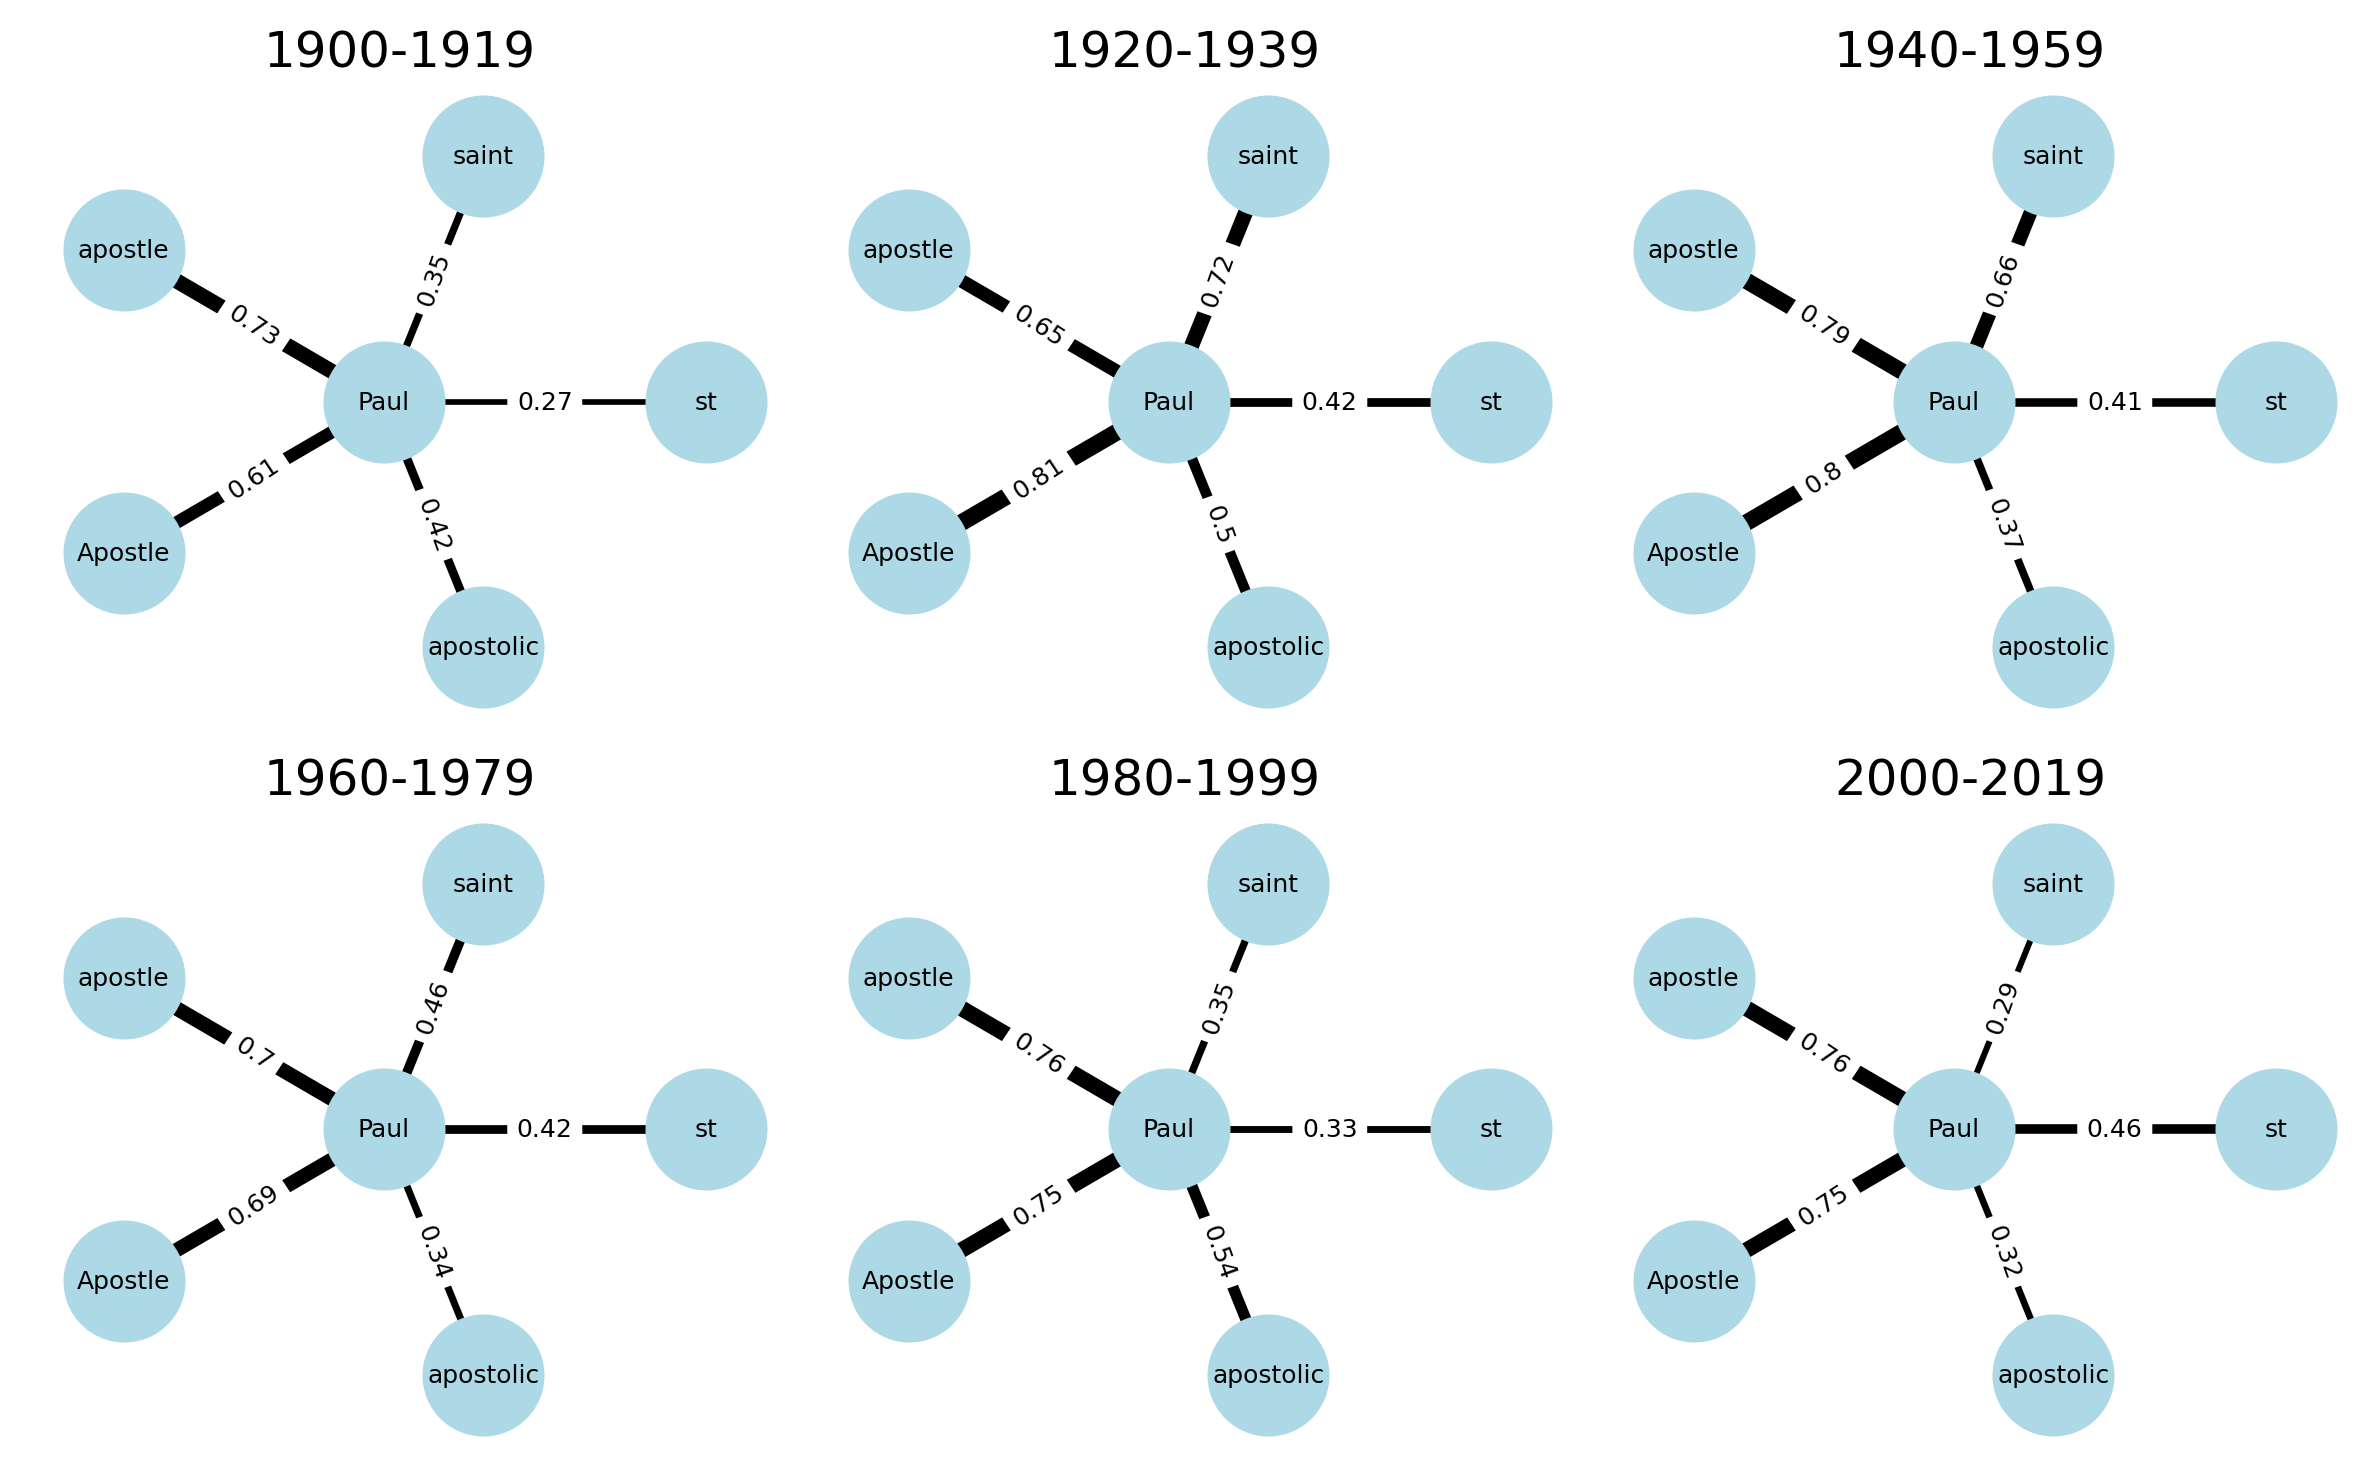

In [28]:
# Draw the graph with edge labels
fig, axs = plt.subplots(2,3, figsize=(8, 5), dpi=300, tight_layout=True)

for ax, bidecade in zip(axs.ravel(), bidecades_strs):
    G = nx.Graph()
    G.add_edges_from(bidecades_data[bidecade])
    edge_sizes = [w *5 for w in nx.get_edge_attributes(G, "weight").values()]
    nx.draw_networkx_nodes(G, pos, node_size=70, node_color="blue", edgecolors="black", ax=ax)#, cmap=plt.cm.binary, ax=ax)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=800, node_color='lightblue', ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_size=6, ax=ax)
    ax.set_title(bidecade)
    ax.set_xlim(-1.1,1.2)
    ax.set_ylim(-1.2,1.2)



In [25]:
fig.savefig("../figures/paul_st_apostle.png")

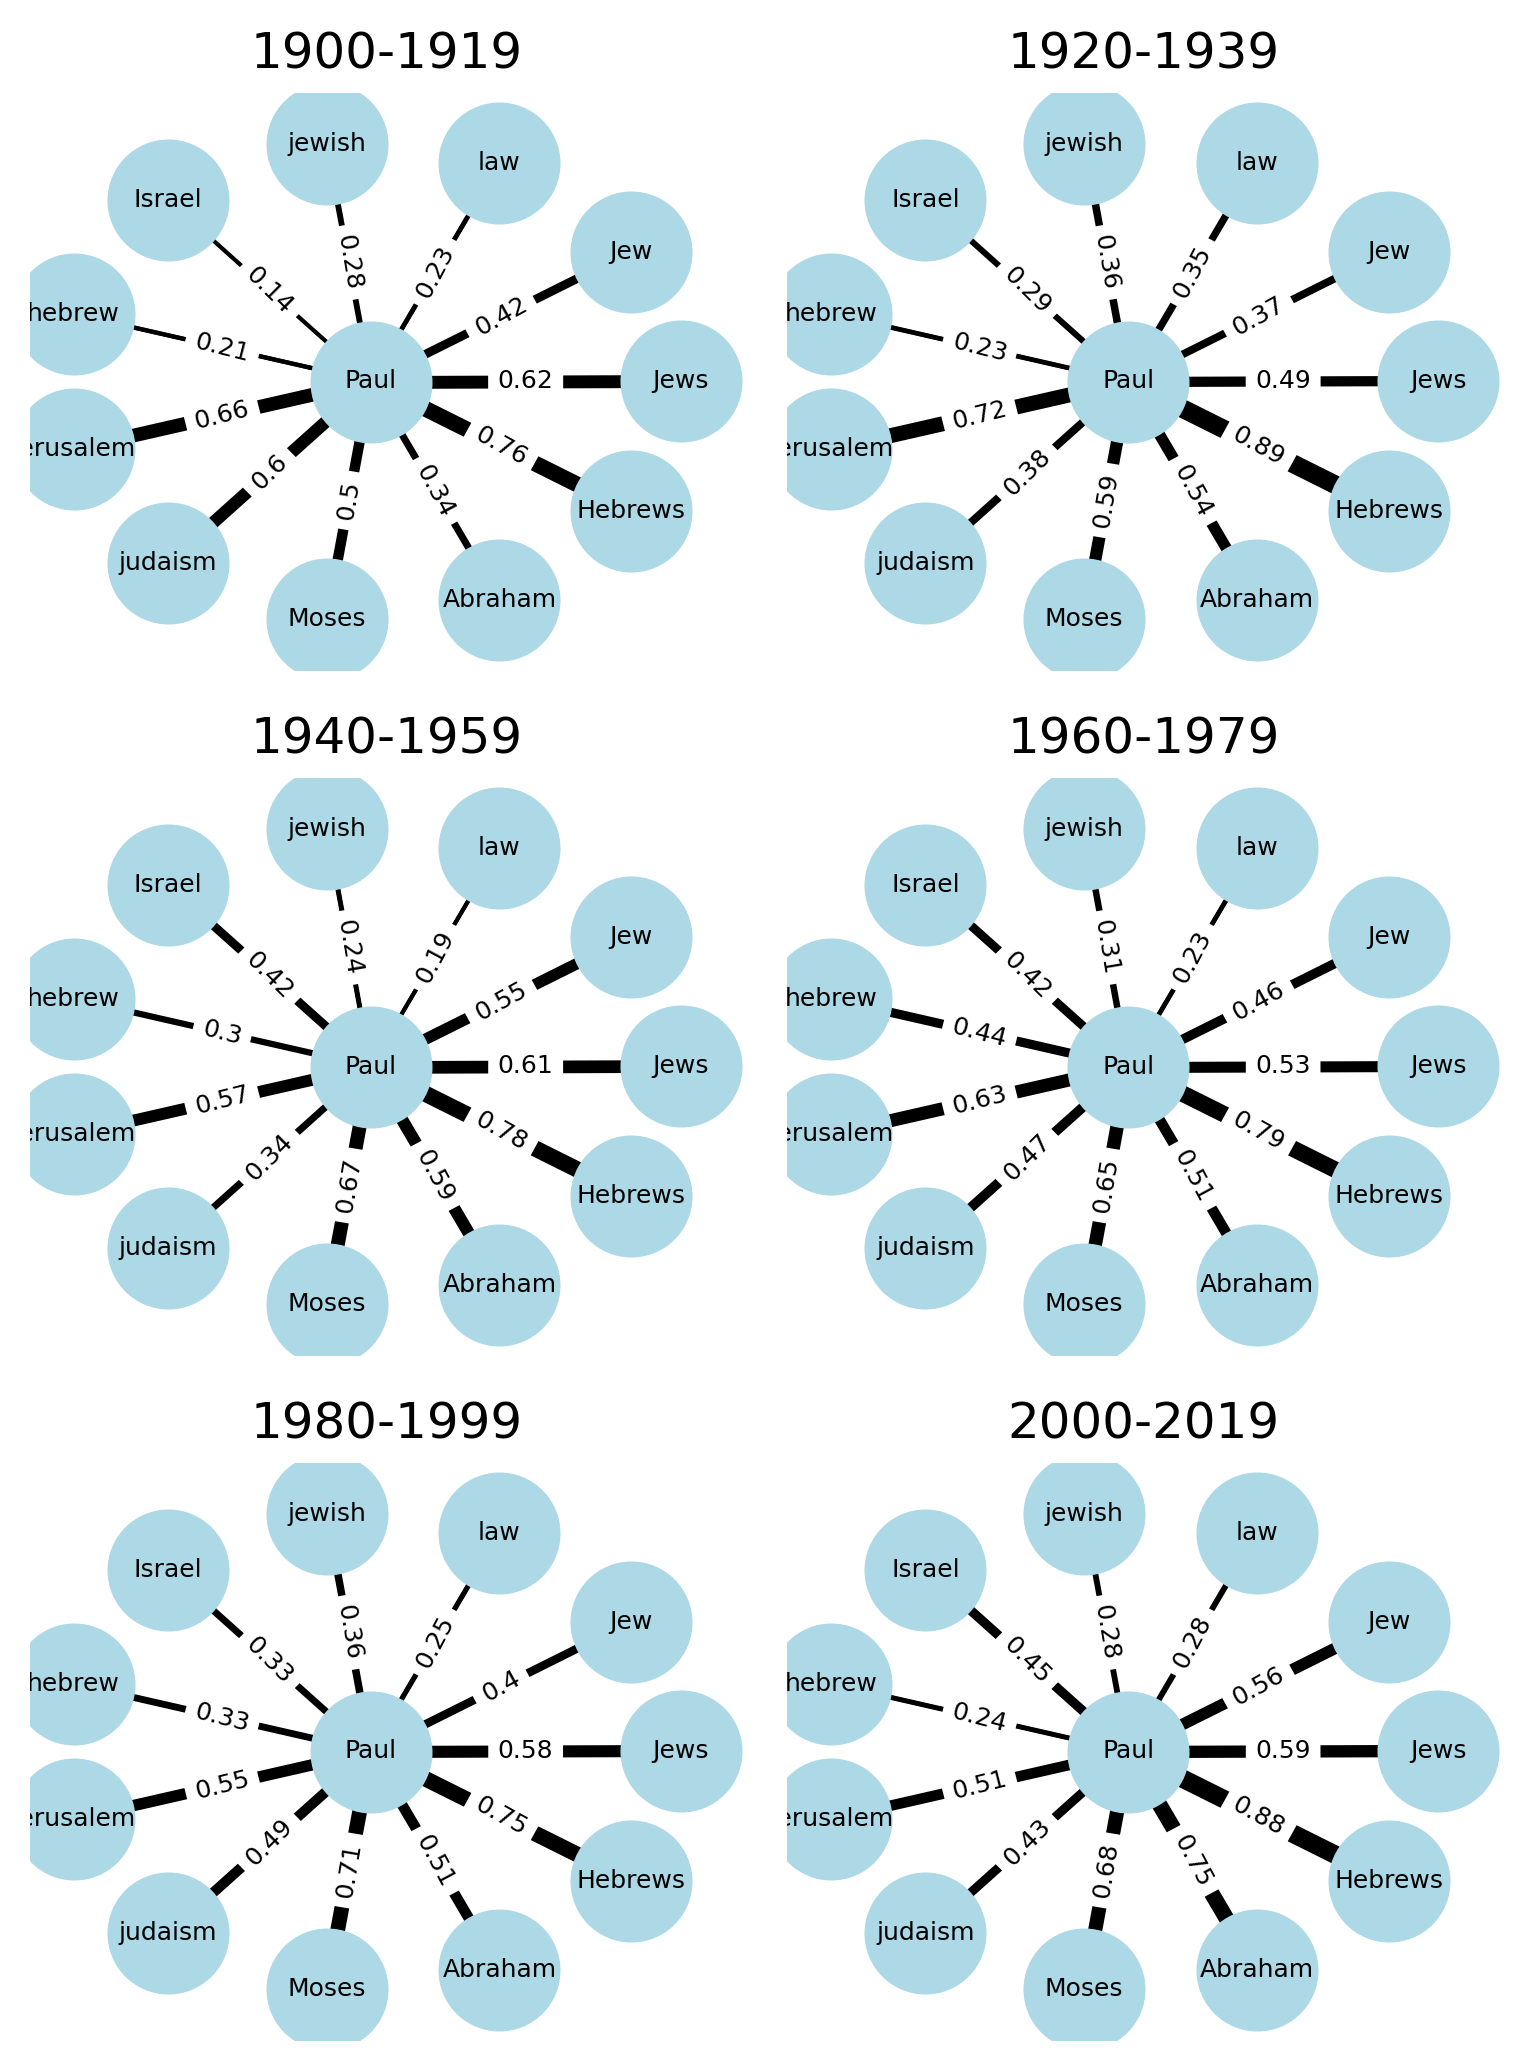

In [26]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 7), dpi=300, tight_layout=True)

for ax, bidecade in zip(axs.ravel(), bidecades_strs):
    source = "Paul"
    targets = jewishness
    topN_mean = np.mean([tup[1] for tup in vectors_dict[bidecade].most_similar(source, topn=10)])
    bidecade_list = []
    for target in targets:
        bidecade_list.append((source, target ,{"weight" : np.round(vectors_dict[bidecade].similarity("Paul", target) / topN_mean, 2)}))
    G = nx.Graph()
    G.add_edges_from(bidecade_list)
    edge_sizes = [w *5 for w in nx.get_edge_attributes(G, "weight").values()]
    pos = nx.circular_layout(G.subgraph(targets))
    pos['Paul'] = (0, 0)
    nx.draw_networkx_nodes(G, pos, node_size=70, node_color="blue", edgecolors="black", ax=ax)#, cmap=plt.cm.binary, ax=ax)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=800, node_color='lightblue', ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_size=6, ax=ax)
    ax.set_title(bidecade)
    ax.set_xlim(-1.1,1.2)
    ax.set_ylim(-1.2,1.2)


In [27]:
fig.savefig("../figures/paul_jewishness.png")

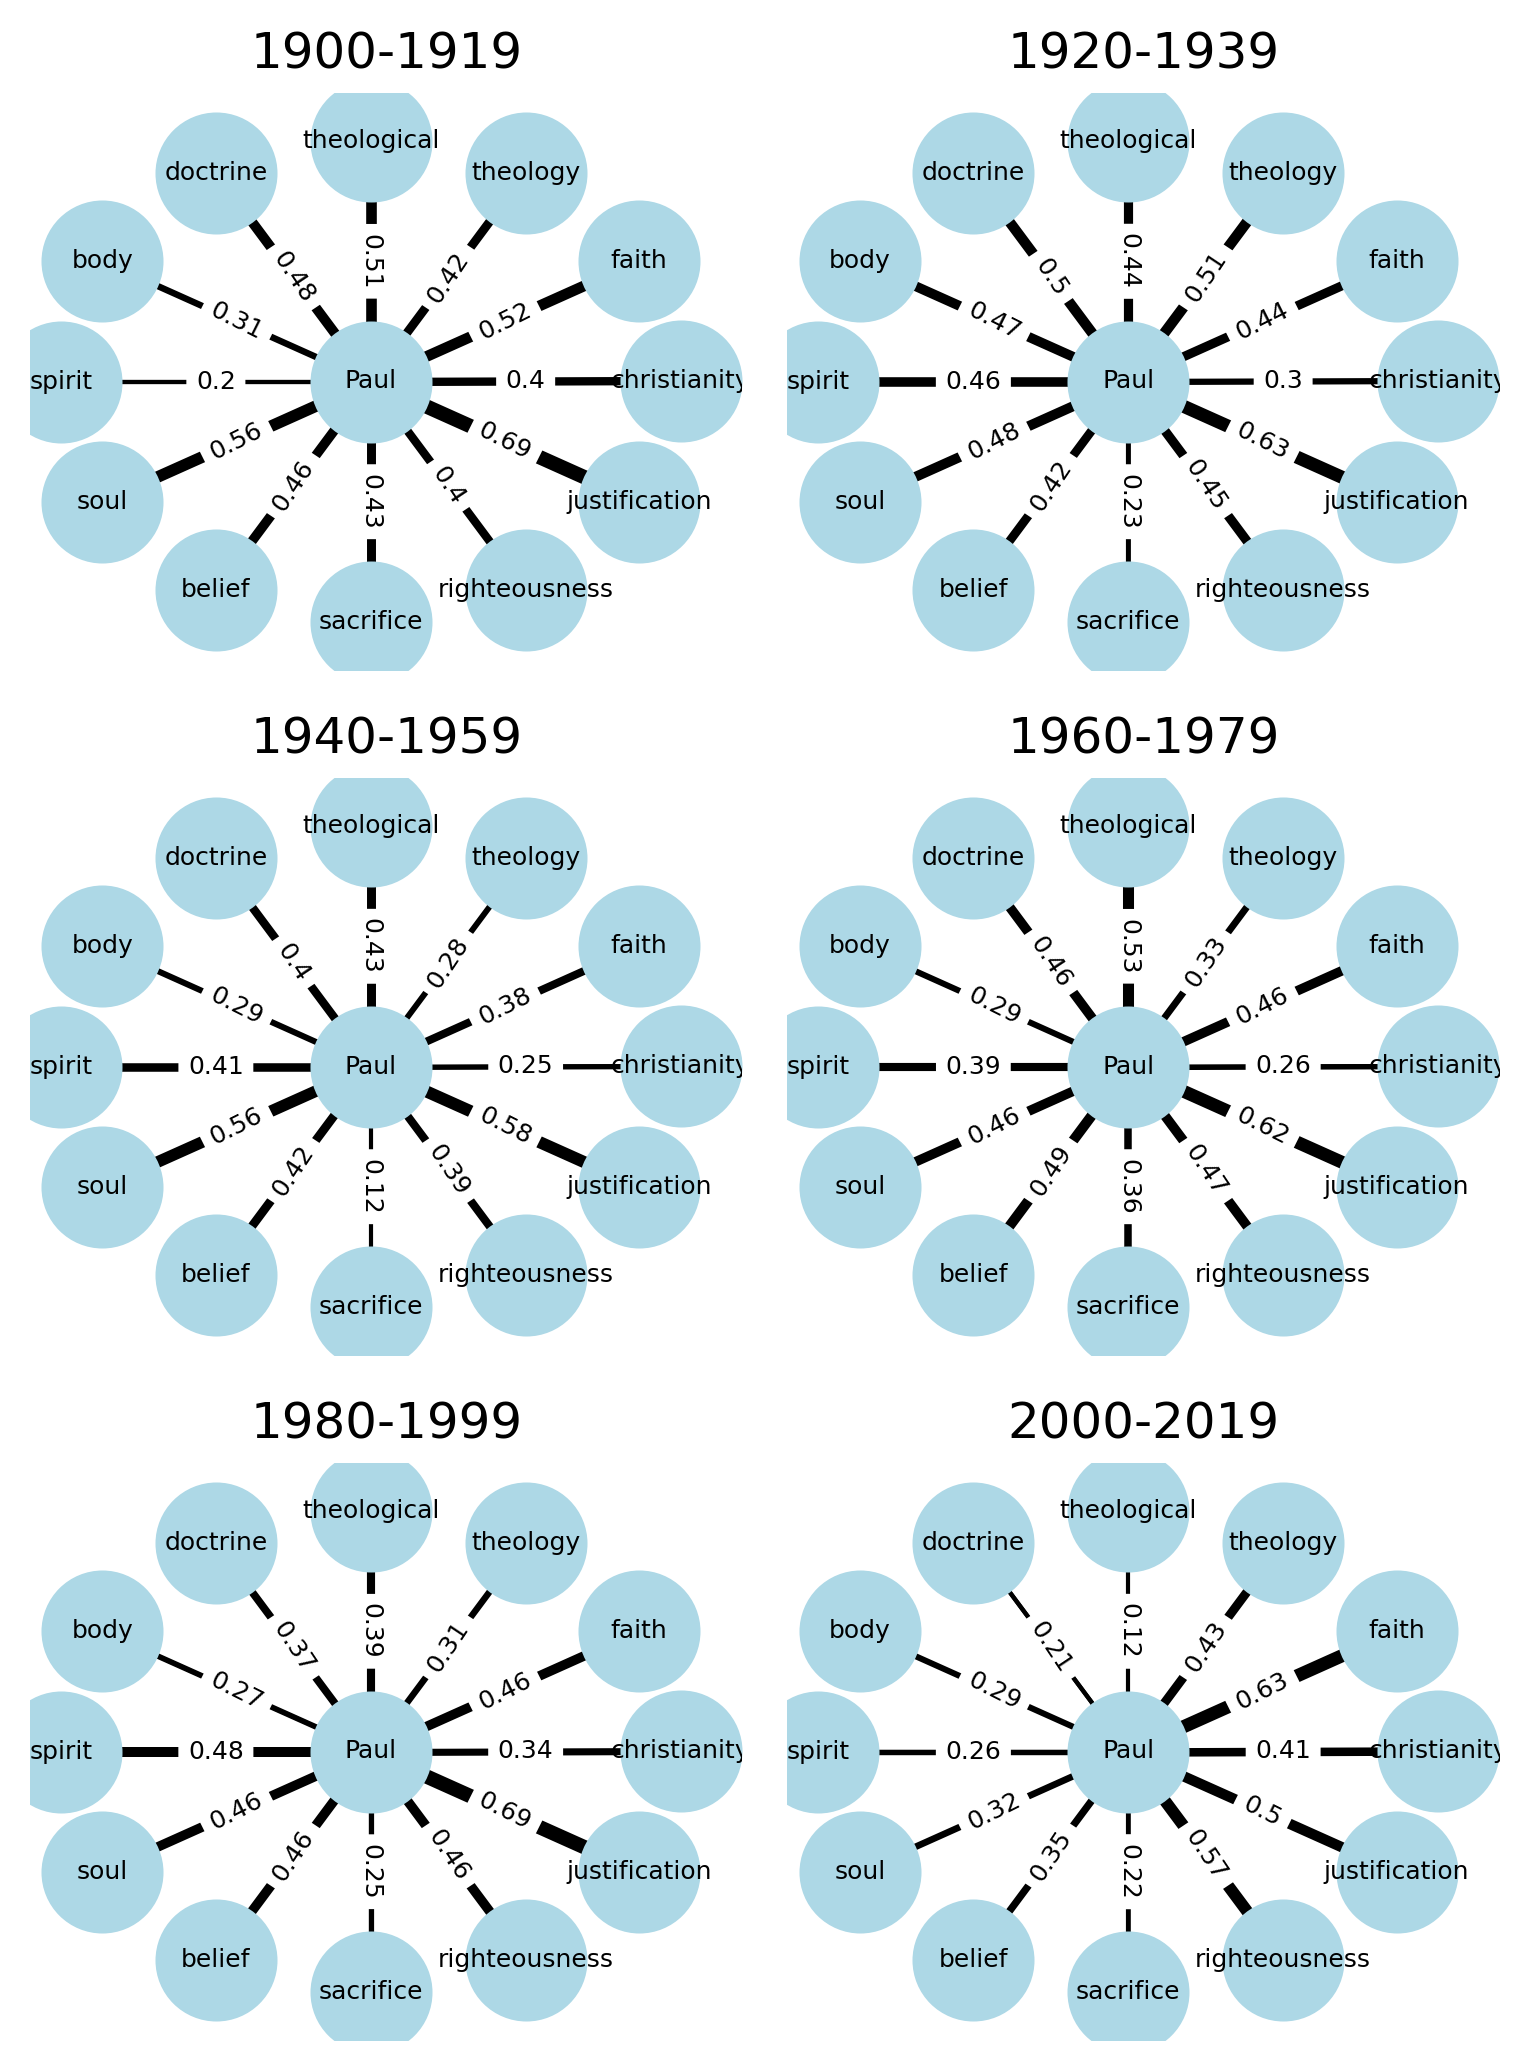

In [28]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 7), dpi=300, tight_layout=True)

for ax, bidecade in zip(axs.ravel(), bidecades_strs):
    source = "Paul"
    targets = doctrine_theology
    topN_mean = np.mean([tup[1] for tup in vectors_dict[bidecade].most_similar(source, topn=10)])
    bidecade_list = []
    for target in targets:
        bidecade_list.append((source, target ,{"weight" : np.round(vectors_dict[bidecade].similarity("Paul", target) / topN_mean, 2)}))
    G = nx.Graph()
    G.add_edges_from(bidecade_list)
    edge_sizes = [w *5 for w in nx.get_edge_attributes(G, "weight").values()]
    pos = nx.circular_layout(G.subgraph(targets))
    pos['Paul'] = (0, 0)
    nx.draw_networkx_nodes(G, pos, node_size=70, node_color="blue", edgecolors="black", ax=ax)#, cmap=plt.cm.binary, ax=ax)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=800, node_color='lightblue', ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_size=6, ax=ax)
    ax.set_title(bidecade)
    ax.set_xlim(-1.1,1.2)
    ax.set_ylim(-1.2,1.2)

In [29]:
fig.savefig("../figures/paul_doctrine_theology.png")

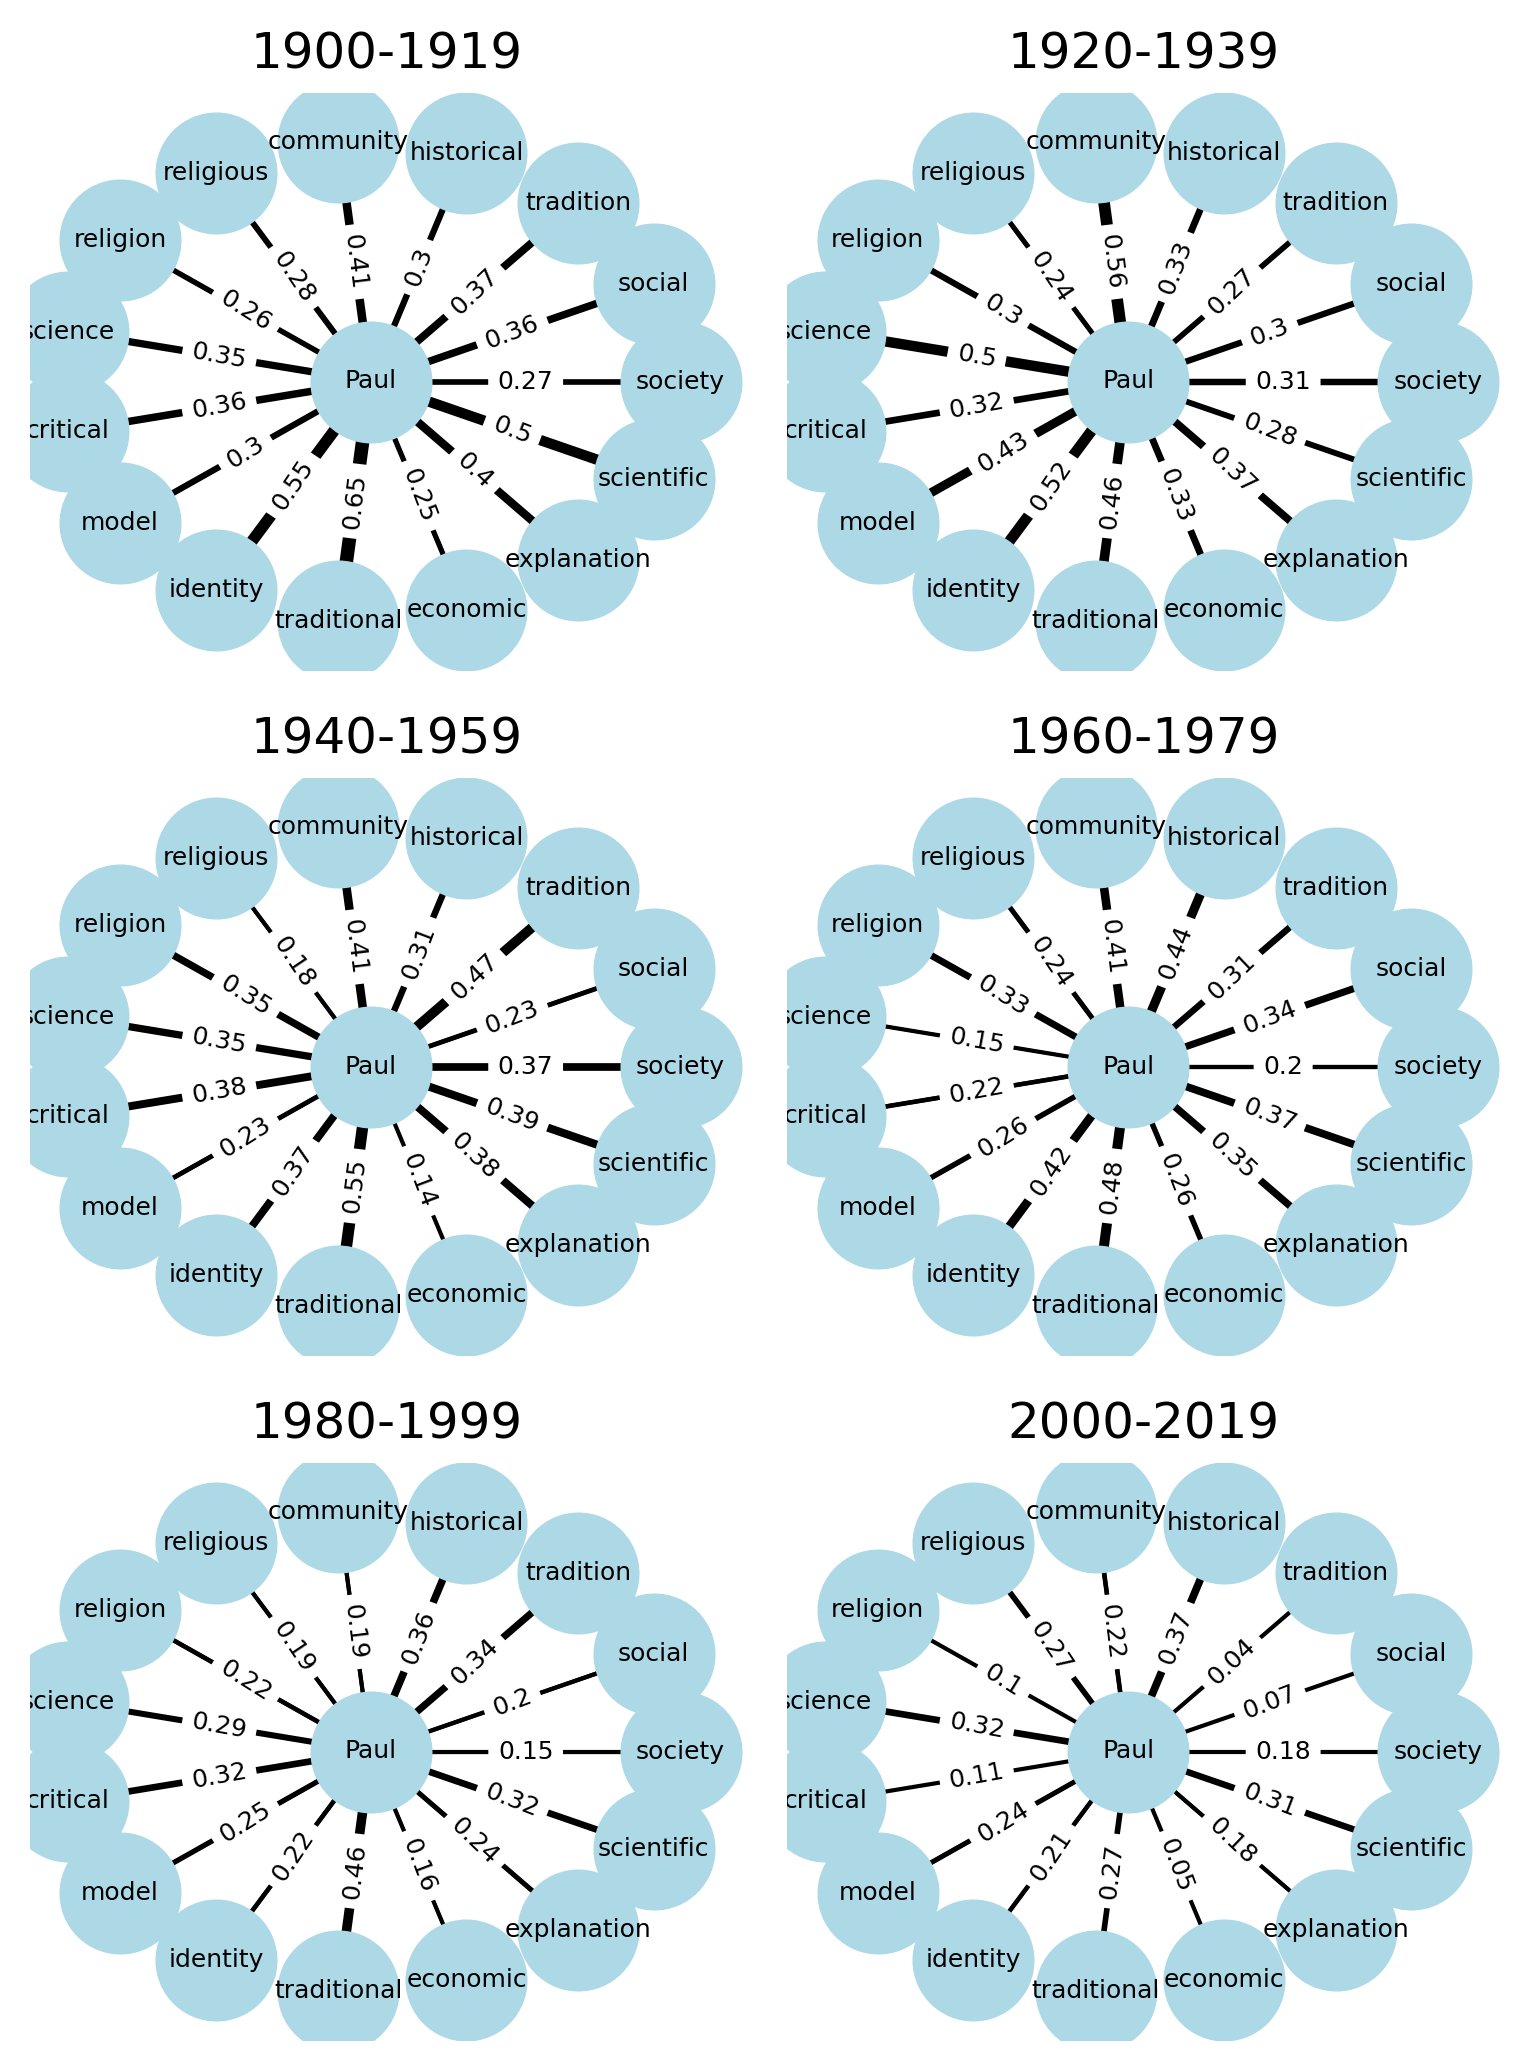

In [30]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 7), dpi=300, tight_layout=True)

for ax, bidecade in zip(axs.ravel(), bidecades_strs):
    source = "Paul"
    targets = academic
    topN_mean = np.mean([tup[1] for tup in vectors_dict[bidecade].most_similar(source, topn=10)])
    bidecade_list = []
    for target in targets:
        bidecade_list.append((source, target ,{"weight" : np.round(vectors_dict[bidecade].similarity("Paul", target) / topN_mean, 2)}))
    G = nx.Graph()
    G.add_edges_from(bidecade_list)
    edge_sizes = [w *5 for w in nx.get_edge_attributes(G, "weight").values()]
    pos = nx.circular_layout(G.subgraph(targets))
    pos['Paul'] = (0, 0)
    nx.draw_networkx_nodes(G, pos, node_size=70, node_color="blue", edgecolors="black", ax=ax)#, cmap=plt.cm.binary, ax=ax)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=800, node_color='lightblue', ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_sizes, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, font_size=6, ax=ax)
    ax.set_title(bidecade)
    ax.set_xlim(-1.1,1.2)
    ax.set_ylim(-1.2,1.2)

In [31]:
fig.savefig("../figures/paul_academic.png")

Tasks:
- look at relations between individual words within categories (especially in the case of doctrine and academic category
- to detect words undrgoing the biggest semantic change from one period to another (might be done for all the target words together)
- nearest neighbors of Paul overtime
- Paul more as a Christian or as a Jew?

# Paul's nearest neighbours over time

In [36]:
paul_neighbors = {}
for bidecade in bidecades_strs:
    paul_neighbors[bidecade] = [tup[0] for tup in vectors_dict[bidecade].most_similar("Paul", topn=20)]
paul_neighbors_df = pd.DataFrame(paul_neighbors)
paul_neighbors_df

,1900-1919,1920-1939,1940-1959,1960-1979,1980-1999,2000-2019
0,clement,Pauls,Pauls,Pauls,Pauls,Titus
1,pastoral,Barnabas,clement,Creed,Augustine,Bonhoeffer
2,Creed,clement,Titus,Augustine,Origen,Benedict
3,Augustine,Pauline,Augustine,Kierkegaard,clement,Corinthians
4,pillar,evangelist,Colossians,Calvin,Calvin,Augustine
5,Philo,Origen,Irenaeus,Gregory,ephesian,Colossians
6,Peter,Peter,Barnabas,thessalonian,Irenaeus,Agamben
7,Pierre,Philippians,Origen,Seneca,Gregory,Edwards
8,galatian,Philemon,Pauline,clement,thessalonian,Pauls
9,Aristotle,elder,Cyril,Peter,Colossians,Calvin


In [ ]:
def get_tsne_coors(keyed_vectors, keys=None, perplexity=18, seed=1):
    if keys != None:
        vectors = keyed_vectors[keys]
        words = np.array(keys)
    else:
        vectors = keyed_vectors.vectors
        words = np.array(keyed_vectors.index_to_key)
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity, init="pca", learning_rate='auto',
                metric='cosine', n_iter=1000)  # dissimilarity="precomputed",
    pos = tsne.fit_transform(vectors)  # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words


xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=30)


def draw_special_words(wordlist, color, xs, ys, words, ax=ax, fontsize=6):
    color_idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    for x, y, w in zip(xs[color_idx], ys[color_idx] - 0.003, words[color_idx]):
        ax.text(x, y, w, horizontalalignment='center', fontsize=fontsize, color=color, zorder=3)


def plot_embeddings(sub, ax=ax):
    keyed_vectors = vectors_seed1_dict[sub]
    xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=5)
    special_words = religion_final + morality_final + morality_extension
    # all words as dots if not in lists
    dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
    ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)
    draw_special_words(religion_final, "green", xs, ys, words, ax=ax)
    draw_special_words(morality_final, "red", xs, ys, words, ax=ax)
    draw_special_words(morality_extension, "orange", xs, ys, words, ax=ax)
    draw_special_words(religion_extension, "lightgreen", xs, ys, words, ax=ax)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_axis_off()
    fig.savefig("../figures/embeddings_{}.png".format(sub))
    return ax